# Coursework for MRI reconstruction (Autumn 2019)

In this tutorial, we provide the data loader to read and process the MRI data in order to ease the difficulty of training your network. By providing this, we hope you focus more on methodology development. Please feel free to change it to suit what you need.

In [1]:
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [3]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [4]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    
    
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
    
#    img_gt = T.center_crop(T.complex_abs(img_gt), [320, 320]).unsqueeze(1)
#    img_und = T.center_crop(T.complex_abs(img_und), [320, 320]).unsqueeze(1)
#     rawdata_und = T.center_crop(T.complex_abs(rawdata_und), [320, 320]).unsqueeze(1)
#     norm = T.center_crop(T.complex_abs(norm), [320, 320]).unsqueeze(1)
#     masks.T.center_crop(T.complex_abs(masks), [320, 320]).unsqueeze(1)    

    img_gt = T.center_crop(T.complex_abs(img_gt), [320, 320])
    img_und = T.center_crop(T.complex_abs(img_und), [320, 320])
        
    return img_gt.squeeze(0), img_und.squeeze(0)


In [5]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list    

In [6]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(128 ,256, kernel_size=3, padding=1),  # 320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 320/320
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # 320/320
            
            
        )

    def forward(self, x):
        x = self.features(x)
        #x = nn.functional.sigmoid(x)
        #x = x * 255
        #x = x.type(torch.cuda.int32)
        return x

In [7]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [8]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        #output = F.relu(self.conv1(x))
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        #output = self.conv2(output)
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class bottleNeck(torch.nn.Module):
    expansion = 4
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(bottleNeck,self).__init__()

        self.conv1 = torch.nn.Conv2d(input_planes,planes,kernel_size=1,stride=1)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.conv3 = torch.nn.Conv2d(planes,planes*self.expansion,kernel_size=1)
        self.bn3 = torch.nn.BatchNorm2d(planes*self.expansion)
        self.dim_change = dim_change
    
    def forward(self,x):
        res = x
        
        output = F.relu(self.bn1(self.conv1(x)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)
        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        #self.bn1   = torch.nn.BatchNorm2d(64)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        
        #self.conv3 = torch.nn.Conv2d(64,64,kernel_size=3,stride=1, padding=1)
        #self.conv4 = torch.nn.Conv2d(64,64,kernel_size=3,stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        #x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        #x = self.conv3(x)
        #x = self.conv4(x)
        x = self.conv3(x)

        return x

In [9]:
from skimage.measure import compare_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [8]:


if __name__ == '__main__':
    
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
    
    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    lr = 3e-3
    
    network = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
    network.to('cuda:0') #move the model on the GPU
    mse_loss = nn.L1Loss().to('cuda:0')
    
    optimizer = optim.Adam(network.parameters(), lr=lr)
    fixed_train_set = []
    for val in data_list['train']:
        if val[2] > 5:
            fixed_train_set.append(val)
    #create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    losses=[]
    mean_loss_list = []
    
    for epoch in range(10):
        i = 0
        for iteration, sample in enumerate(train_loader):
            i += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = network(img_und)       #feedforward
            #output = output.squeeze(1).cpu().detach().numpy()

            loss = mse_loss(output, img_gt)
            #loss = torch.tensor(ssim(img_gt, output)).to('cuda:0')
            #print(loss.item())
            optimizer.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer.step()     #update the weights
            mean_loss_list.append(loss.item())
            if i%5 == 0:
                print(np.round(np.mean(mean_loss_list), decimals = 5), "  ", i, "  ", epoch+1)
                mean_loss_list = []
            losses.append(loss.item() * img_gt.size(0))
        #epoch_loss = running_loss / len(train_loader['train'])
        #losses.append(epoch_loss)
        #plt.plot(np.array(loss_values), 'r')
        
#         stack different slices into a volume for visualisation
#         A = masks[...,0].squeeze()
#         B = torch.log(T.complex_abs(rawdata_und) + 1e-9).squeeze()
#         C = T.complex_abs(img_und).squeeze()
#         D = T.complex_abs(img_gt).squeeze()
#         all_imgs = torch.stack([A,B,C,D], dim=0)

#         # from left to right: mask, masked kspace, undersampled image, ground truth
#         show_slices(all_imgs, [0, 1, 2, 3], cmap='gray')
#         plt.pause(1)

#         if iteration >= 0: break  # show 4 random slices
        

4.62747    5    1
0.9564    10    1
0.32924    15    1
0.18278    20    1
0.17471    25    1
0.17419    30    1
0.24226    35    1
0.18267    40    1
0.15837    45    1
0.1895    50    1
0.15642    55    1
0.14957    60    1
0.09307    65    1
0.11925    70    1
0.15277    75    1
0.13466    80    1
0.16973    85    1
0.14031    90    1
0.13438    95    1
0.12168    100    1
0.10816    105    1
0.13205    110    1
0.12234    115    1
0.10517    120    1
0.12942    125    1
0.10189    130    1
0.1059    135    1
0.08884    140    1
0.09547    145    1
0.10542    150    1
0.09815    155    1
0.10129    160    1
0.10725    165    1
0.10297    170    1
0.09847    175    1
0.09742    180    1
0.09349    185    1
0.08535    190    1
0.12456    195    1
0.09368    200    1
0.08889    205    1
0.08678    210    1
0.10722    215    1
0.10639    220    1
0.10914    225    1
0.07276    230    1
0.09004    235    1
0.11592    240    1
0.08571    245    1
0.07772    250    1
0.09459    255    1
0.1

0.06033    2025    1
0.07399    2030    1
0.08785    2035    1
0.07377    2040    1
0.08381    2045    1
0.06851    2050    1
0.07567    2055    1
0.07705    2060    1
0.0796    5    2
0.07415    10    2
0.07558    15    2
0.08032    20    2
0.08101    25    2
0.09445    30    2
0.08751    35    2
0.07905    40    2
0.08722    45    2
0.06215    50    2
0.06737    55    2
0.06797    60    2
0.06528    65    2
0.07839    70    2
0.07456    75    2
0.06666    80    2
0.07822    85    2
0.09023    90    2
0.07577    95    2
0.08047    100    2
0.07171    105    2
0.08654    110    2
0.05907    115    2
0.06483    120    2
0.06494    125    2
0.05712    130    2
0.05711    135    2
0.08581    140    2
0.07369    145    2
0.06915    150    2
0.06843    155    2
0.07049    160    2
0.07115    165    2
0.06193    170    2
0.07164    175    2
0.0662    180    2
0.07758    185    2
0.05892    190    2
0.08789    195    2
0.05967    200    2
0.07644    205    2
0.06366    210    2
0.08109    215

0.08326    1980    2
0.05539    1985    2
0.07703    1990    2
0.08047    1995    2
0.08946    2000    2
0.0768    2005    2
0.07252    2010    2
0.08963    2015    2
0.08667    2020    2
0.06405    2025    2
0.0624    2030    2
0.07933    2035    2
0.08101    2040    2
0.06785    2045    2
0.07925    2050    2
0.06396    2055    2
0.08274    2060    2
0.07669    5    3
0.07008    10    3
0.07151    15    3
0.08044    20    3
0.05701    25    3
0.0729    30    3
0.06644    35    3
0.07446    40    3
0.07775    45    3
0.08097    50    3
0.07891    55    3
0.09241    60    3
0.06532    65    3
0.07724    70    3
0.05134    75    3
0.05733    80    3
0.07667    85    3
0.08262    90    3
0.06385    95    3
0.071    100    3
0.05572    105    3
0.06411    110    3
0.06939    115    3
0.05559    120    3
0.08613    125    3
0.06527    130    3
0.07158    135    3
0.07683    140    3
0.07121    145    3
0.06717    150    3
0.07226    155    3
0.0708    160    3
0.0609    165    3
0.08025   

0.07122    1935    3
0.06341    1940    3
0.06951    1945    3
0.07329    1950    3
0.0703    1955    3
0.07305    1960    3
0.06251    1965    3
0.084    1970    3
0.08184    1975    3
0.06687    1980    3
0.07316    1985    3
0.08451    1990    3
0.06891    1995    3
0.06215    2000    3
0.0668    2005    3
0.06976    2010    3
0.06592    2015    3
0.0589    2020    3
0.06269    2025    3
0.05989    2030    3
0.06652    2035    3
0.07306    2040    3
0.06696    2045    3
0.07169    2050    3
0.07103    2055    3
0.07021    2060    3
0.06055    5    4
0.074    10    4
0.06593    15    4
0.06356    20    4
0.0706    25    4
0.07958    30    4
0.07039    35    4
0.05119    40    4
0.07063    45    4
0.07451    50    4
0.07096    55    4
0.06482    60    4
0.08364    65    4
0.06211    70    4
0.07343    75    4
0.0527    80    4
0.06144    85    4
0.05879    90    4
0.05635    95    4
0.0695    100    4
0.09308    105    4
0.07582    110    4
0.07362    115    4
0.07677    120    4
0.06

0.05654    1890    4
0.08006    1895    4
0.07286    1900    4
0.06265    1905    4
0.0595    1910    4
0.05656    1915    4
0.07247    1920    4
0.06679    1925    4
0.06876    1930    4
0.06848    1935    4
0.06065    1940    4
0.06196    1945    4
0.06987    1950    4
0.07381    1955    4
0.06152    1960    4
0.05936    1965    4
0.0581    1970    4
0.0845    1975    4
0.09866    1980    4
0.08119    1985    4
0.06286    1990    4
0.06142    1995    4
0.05736    2000    4
0.06774    2005    4
0.06867    2010    4
0.06108    2015    4
0.063    2020    4
0.06732    2025    4
0.06422    2030    4
0.07331    2035    4
0.08216    2040    4
0.07527    2045    4
0.06821    2050    4
0.07067    2055    4
0.07614    2060    4
0.07016    5    5
0.06294    10    5
0.08143    15    5
0.06481    20    5
0.07643    25    5
0.06478    30    5
0.06675    35    5
0.06084    40    5
0.0576    45    5
0.07535    50    5
0.05138    55    5
0.07226    60    5
0.07885    65    5
0.06488    70    5
0.0738

0.06651    1845    5
0.07507    1850    5
0.06446    1855    5
0.05666    1860    5
0.08225    1865    5
0.05662    1870    5
0.06089    1875    5
0.06113    1880    5
0.07198    1885    5
0.05872    1890    5
0.06378    1895    5
0.05528    1900    5
0.07024    1905    5
0.05607    1910    5
0.05562    1915    5
0.06925    1920    5
0.06987    1925    5
0.05224    1930    5
0.07006    1935    5
0.05878    1940    5
0.05915    1945    5
0.05332    1950    5
0.05887    1955    5
0.0542    1960    5
0.06789    1965    5
0.07414    1970    5
0.05996    1975    5
0.06777    1980    5
0.06815    1985    5
0.08106    1990    5
0.0563    1995    5
0.0459    2000    5
0.05804    2005    5
0.07053    2010    5
0.07502    2015    5
0.05455    2020    5
0.05451    2025    5
0.07604    2030    5
0.05656    2035    5
0.09385    2040    5
0.05615    2045    5
0.07496    2050    5
0.06861    2055    5
0.0779    2060    5
0.07594    5    6
0.04539    10    6
0.07458    15    6
0.06766    20    6
0.066

0.061    1805    6
0.05178    1810    6
0.07759    1815    6
0.06643    1820    6
0.06983    1825    6
0.07316    1830    6
0.05889    1835    6
0.06815    1840    6
0.08127    1845    6
0.06519    1850    6
0.06893    1855    6
0.06944    1860    6
0.07834    1865    6
0.06243    1870    6
0.07009    1875    6
0.06677    1880    6
0.06451    1885    6
0.06695    1890    6
0.06449    1895    6
0.06808    1900    6
0.05834    1905    6
0.06646    1910    6
0.0462    1915    6
0.06597    1920    6
0.06171    1925    6
0.08224    1930    6
0.05908    1935    6
0.07757    1940    6
0.04956    1945    6
0.07711    1950    6
0.06144    1955    6
0.06971    1960    6
0.07106    1965    6
0.0506    1970    6
0.08255    1975    6
0.06209    1980    6
0.06036    1985    6
0.08328    1990    6
0.07602    1995    6
0.05929    2000    6
0.05856    2005    6
0.06093    2010    6
0.06156    2015    6
0.06186    2020    6
0.0569    2025    6
0.06925    2030    6
0.07468    2035    6
0.05509    2040   

0.05635    1760    7
0.07294    1765    7
0.04731    1770    7
0.0627    1775    7
0.06497    1780    7
0.08246    1785    7
0.07558    1790    7
0.0661    1795    7
0.06961    1800    7
0.06846    1805    7
0.05331    1810    7
0.05846    1815    7
0.05964    1820    7
0.06492    1825    7
0.07249    1830    7
0.06768    1835    7
0.05292    1840    7
0.05298    1845    7
0.06068    1850    7
0.0553    1855    7
0.07619    1860    7
0.06724    1865    7
0.07119    1870    7
0.05765    1875    7
0.06771    1880    7
0.06291    1885    7
0.05194    1890    7
0.05568    1895    7
0.06607    1900    7
0.05801    1905    7
0.06018    1910    7
0.08444    1915    7
0.06611    1920    7
0.0836    1925    7
0.06486    1930    7
0.05417    1935    7
0.0817    1940    7
0.07221    1945    7
0.05836    1950    7
0.07251    1955    7
0.06368    1960    7
0.07726    1965    7
0.05527    1970    7
0.05746    1975    7
0.07233    1980    7
0.06732    1985    7
0.06496    1990    7
0.04625    1995   

0.07631    1715    8
0.07811    1720    8
0.06787    1725    8
0.05779    1730    8
0.08064    1735    8
0.07003    1740    8
0.06818    1745    8
0.06731    1750    8
0.06466    1755    8
0.06824    1760    8
0.06083    1765    8
0.04415    1770    8
0.06481    1775    8
0.06641    1780    8
0.05151    1785    8
0.08652    1790    8
0.0423    1795    8
0.07031    1800    8
0.06828    1805    8
0.06473    1810    8
0.06608    1815    8
0.05504    1820    8
0.05286    1825    8
0.08291    1830    8
0.07804    1835    8
0.05971    1840    8
0.05623    1845    8
0.05968    1850    8
0.06145    1855    8
0.06524    1860    8
0.07037    1865    8
0.07207    1870    8
0.05299    1875    8
0.07389    1880    8
0.06371    1885    8
0.06816    1890    8
0.06553    1895    8
0.0597    1900    8
0.05579    1905    8
0.06667    1910    8
0.04784    1915    8
0.06368    1920    8
0.05971    1925    8
0.06348    1930    8
0.07002    1935    8
0.05206    1940    8
0.05415    1945    8
0.05134    1950

0.06279    1670    9
0.0796    1675    9
0.0543    1680    9
0.07999    1685    9
0.07122    1690    9
0.05341    1695    9
0.07501    1700    9
0.06299    1705    9
0.06902    1710    9
0.0545    1715    9
0.06037    1720    9
0.07124    1725    9
0.0706    1730    9
0.05962    1735    9
0.0669    1740    9
0.0619    1745    9
0.06529    1750    9
0.05419    1755    9
0.0756    1760    9
0.06516    1765    9
0.06628    1770    9
0.07844    1775    9
0.05969    1780    9
0.07449    1785    9
0.05632    1790    9
0.07444    1795    9
0.0645    1800    9
0.06492    1805    9
0.06097    1810    9
0.05814    1815    9
0.08417    1820    9
0.06481    1825    9
0.06687    1830    9
0.07575    1835    9
0.05435    1840    9
0.04946    1845    9
0.06558    1850    9
0.06307    1855    9
0.0646    1860    9
0.05515    1865    9
0.06491    1870    9
0.07333    1875    9
0.07314    1880    9
0.07699    1885    9
0.06314    1890    9
0.06098    1895    9
0.04863    1900    9
0.0658    1905    9
0.

0.05481    1550    10
0.06943    1555    10
0.06153    1560    10
0.06264    1565    10
0.07024    1570    10
0.04334    1575    10
0.06696    1580    10
0.05566    1585    10
0.05699    1590    10
0.06208    1595    10
0.04538    1600    10
0.07667    1605    10
0.05348    1610    10
0.05774    1615    10
0.05615    1620    10
0.05573    1625    10
0.06007    1630    10
0.06855    1635    10
0.0621    1640    10
0.07687    1645    10
0.05627    1650    10
0.05122    1655    10
0.0706    1660    10
0.05748    1665    10
0.0635    1670    10
0.05808    1675    10
0.04999    1680    10
0.04663    1685    10
0.06272    1690    10
0.07101    1695    10
0.06079    1700    10
0.0635    1705    10
0.06716    1710    10
0.07063    1715    10
0.06985    1720    10
0.06704    1725    10
0.05508    1730    10
0.06024    1735    10
0.06503    1740    10
0.04956    1745    10
0.05496    1750    10
0.05255    1755    10
0.0525    1760    10
0.05495    1765    10
0.06765    1770    10
0.06299    1775

In [29]:
#bs-batch size, ep - epoch, lr - learning rate, bd - block dimensions
torch.save(model.state_dict(), "/home/students/mxx941/work/bs1_ep12_lr8e-3_bd2-2-2-2-3-3-3-3-2-2-2-2.pt")


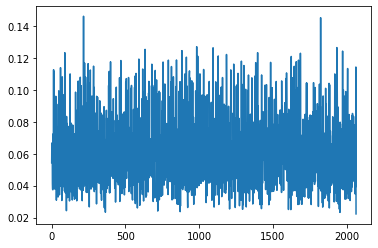

In [31]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [11]:
gt, image = train_dataset[2]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
print(image.shape)
#gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.unsqueeze(0).numpy()
output = network(image)
output = output.squeeze(1).cpu().detach().numpy()
loss = torch.tensor(ssim(gt, output))
loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
print(loss.item())
print(loss2.item())
#loss2 = mse_loss(output, gt)
len(train_dataset)

torch.Size([1, 1, 320, 320])
0.5423479676246643
0.4367396831512451


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


2064

In [12]:
e = []
a=[]
b=[]
i = 0
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    output = network(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.05506592344983604
0.49527849644682437


0.0614366997610922


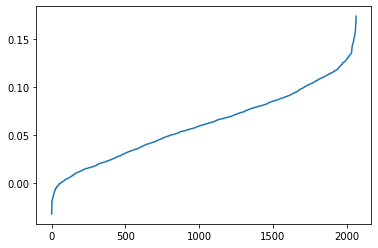

In [56]:
listaaa = []
for i in e:
    #if i < 0:
    listaaa.append(i)
print(np.mean(listaaa))
LISTAAA = listaaa.sort()
plt.plot(listaaa)

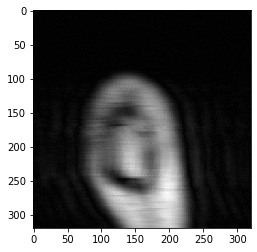

In [39]:

gt, image = train_dataset[e.index(max(e))]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
#gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.numpy()
#model.to("cuda:0")
output = model(image)
output = output.squeeze(1).cpu().detach().numpy()
net_out = output.squeeze(0)
plt.imshow(image.squeeze(0).squeeze(0).cpu(), cmap='gray')



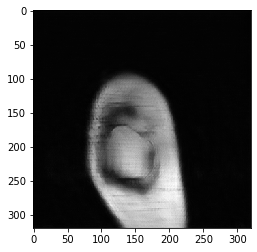

In [40]:
plt.imshow(net_out, cmap='gray')

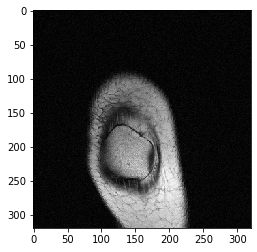

In [41]:
plt.imshow(gt, cmap='gray')

In [22]:
gt, image = train_dataset[3]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.unsqueeze(0)
output = network(image)
loss = mse_loss(output, gt)
loss2 = mse_loss(image, gt)
print(loss.item())
print(loss2.item())

0.03466785326600075
0.04140409082174301


In [59]:
e = []
a=[]
b=[]
i = 0
model.to("cuda:0")
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.060224389043716034
0.49987494857447556


In [50]:
e = []
a=[]
b=[]
i = 0
for i in range(0,3):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    network.to("cuda:0")
    output = network(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.06027336915334066
0.577251931031545


In [11]:
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
model.load_state_dict(torch.load("/home/students/mxx941/work/bs1_ep10_lr8e-3_bd2-2-2-2-3-3-3-3-2-2-2-2.pt"))
model.train()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [65]:
if __name__ == '__main__':
    
#     data_path_train = '/data/local/NC2019MRI/train'
#     data_path_val = '/data/local/NC2019MRI/train'
#     data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
    
#     acc = 8
#     cen_fract = 0.04
#     seed = False # random masks for each slice 
#     num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
#     lr = 2e-3
    
    
#     model.to('cuda:0') #move the model on the GPU
#     mse_loss = nn.L1Loss().to('cuda:0')
    
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     fixed_train_set = []
#     for val in data_list['train']:
#         if val[2] > 5:
#             fixed_train_set.append(val)
#     #create data loader for training set. It applies same to validation set as well
#     train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
#     train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    losses=[]
    mean_loss_list = []
    
    for epoch in range(2):
        i = 0
        for iteration, sample in enumerate(train_loader):
            i += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = model(img_und)       #feedforward
            #output = output.squeeze(1).cpu().detach().numpy()

            loss = mse_loss(output, img_gt)
            #loss = torch.tensor(ssim(img_gt, output)).to('cuda:0')
            #print(loss.item())
            optimizer.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer.step()     #update the weights
            mean_loss_list.append(loss.item())
            if i%5 == 0:
                print(np.round(np.mean(mean_loss_list), decimals = 5), "  ", i, "  ", epoch+1)
                mean_loss_list = []
            losses.append(loss.item() * img_gt.size(0))
        #epoch_loss = running_loss / len(train_loader['train'])
        #losses.append(epoch_loss)
        #plt.plot(np.array(loss_values), 'r')
        
#         stack different slices into a volume for visualisation
#         A = masks[...,0].squeeze()
#         B = torch.log(T.complex_abs(rawdata_und) + 1e-9).squeeze()
#         C = T.complex_abs(img_und).squeeze()
#         D = T.complex_abs(img_gt).squeeze()
#         all_imgs = torch.stack([A,B,C,D], dim=0)

#         # from left to right: mask, masked kspace, undersampled image, ground truth
#         show_slices(all_imgs, [0, 1, 2, 3], cmap='gray')
#         plt.pause(1)

#         if iteration >= 0: break  # show 4 random slices
        e = []
        a=[]
        j = 0
        model.to("cuda:0")
        for j in range(0,len(train_dataset)):
            gt, image = train_dataset[j]
            image = image.unsqueeze(0).to('cuda:0')
            image = image.unsqueeze(0)
            #gt = gt.unsqueeze(0).to('cuda:0')
            gt = gt.unsqueeze(0).numpy()
            output = model(image)
            output = output.squeeze(1).cpu().detach().numpy()
            loss = torch.tensor(ssim(gt, output))
            loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
            e.append(loss.item()-loss2.item())
            a.append(loss.item())

            if loss.item()-loss2.item() < 0:
                j+=1
        print(np.nanmean(e))
        print(np.nanmean(a))

0.06432    5    1
0.06858    10    1
0.05902    15    1
0.0775    20    1
0.05097    25    1
0.06696    30    1
0.06568    35    1
0.05059    40    1
0.05849    45    1
0.06364    50    1
0.06537    55    1
0.05413    60    1
0.06892    65    1
0.04975    70    1
0.06263    75    1
0.04893    80    1
0.0526    85    1
0.05753    90    1
0.05431    95    1
0.056    100    1
0.05543    105    1
0.07255    110    1
0.05389    115    1
0.03782    120    1
0.05231    125    1
0.06877    130    1
0.07659    135    1
0.06128    140    1
0.05774    145    1
0.06887    150    1
0.05794    155    1
0.06433    160    1
0.07324    165    1
0.05193    170    1
0.06883    175    1
0.06636    180    1
0.06433    185    1
0.06454    190    1
0.0651    195    1
0.05636    200    1
0.06911    205    1
0.05354    210    1
0.0596    215    1
0.0833    220    1
0.06052    225    1
0.05909    230    1
0.05078    235    1
0.0513    240    1
0.0399    245    1
0.05583    250    1
0.06114    255    1
0.05594  

0.07149    2025    1
0.06124    2030    1
0.05868    2035    1
0.05327    2040    1
0.05083    2045    1
0.06151    2050    1
0.04927    2055    1
0.0665    2060    1


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.06957006993046565
0.509348879077349
0.05549    5    2
0.06652    10    2
0.07162    15    2
0.0532    20    2
0.05189    25    2
0.04686    30    2
0.05762    35    2
0.06462    40    2
0.06174    45    2
0.05139    50    2
0.0509    55    2
0.05323    60    2
0.05836    65    2
0.05851    70    2
0.04854    75    2
0.0516    80    2
0.06624    85    2
0.05131    90    2
0.06594    95    2
0.04449    100    2
0.07139    105    2
0.04619    110    2
0.06151    115    2
0.06811    120    2
0.05423    125    2
0.05481    130    2
0.06154    135    2
0.04762    140    2
0.04784    145    2
0.0639    150    2
0.06209    155    2
0.07202    160    2
0.05801    165    2
0.0625    170    2
0.08324    175    2
0.0622    180    2
0.06842    185    2
0.04861    190    2
0.05762    195    2
0.06215    200    2
0.06549    205    2
0.07943    210    2
0.07828    215    2
0.05429    220    2
0.05407    225    2
0.06093    230    2
0.06376    235    2
0.06764    240    2
0.05384    245    2
0.06151 

0.05493    2010    2
0.05051    2015    2
0.05798    2020    2
0.05698    2025    2
0.06082    2030    2
0.05906    2035    2
0.05046    2040    2
0.0616    2045    2
0.06833    2050    2
0.06741    2055    2
0.0569    2060    2
0.0629460851936204
0.5030236575651423


In [66]:
lr = 1e-3